In [1]:
from google.colab import drive
drive.mount('/content/drive')






Mounted at /content/drive


In [2]:
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [3]:
data_dir = '/content/drive/MyDrive/Potato'

validation_split = 0.2
seed = 42


In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2  # 80% train, 20% val
)

In [5]:

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # for 3 classes
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 1722 images belonging to 3 classes.
Found 430 images belonging to 3 classes.


In [6]:
print("Class indices:", train_generator.class_indices)


Class indices: {'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}


In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001),input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu',kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu',kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 output classes
])


model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # use categorical since you have 3 classes
    metrics=['accuracy']
)


model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,246,339 (84.86 MB)

 Trainable params: 22,245,891 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:

# Callbacks
checkpoint = ModelCheckpoint('best_cnn_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint, early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7162 - loss: 2.5053
Epoch 1: val_accuracy improved from -inf to 0.06977, saving model to best_cnn_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 579s 11s/step - accuracy: 0.7175 - loss: 2.4891 - val_accuracy: 0.0698 - val_loss: 19.0299
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8949 - loss: 0.5002
Epoch 2: val_accuracy did not improve from 0.06977
54/54 ━━━━━━━━━━━━━━━━━━━━ 353s 7s/step - accuracy: 0.8947 - loss: 0.5005 - val_accuracy: 0.0698 - val_loss: 26.4708
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8741 - loss: 0.5022
Epoch 3: val_accuracy did not improve from 0.06977
54/54 ━━━━━━━━━━━━━━━━━━━━ 346s 6s/step - accuracy: 0.8743 - loss: 0.5015 - val_accuracy: 0.0698 - val_loss: 24.8828
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8842 - loss: 0.4358
Epoch 4: val_accuracy improved from 0.06977 to 0.14884, saving model to best_cnn_model.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 372s

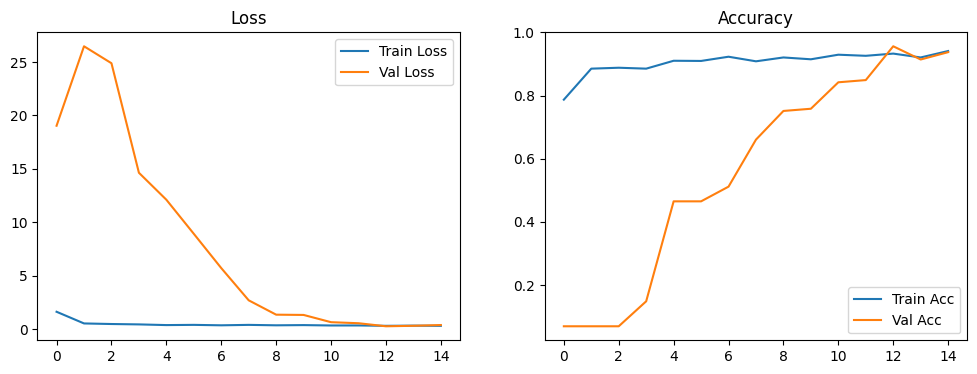

In [9]:
# 5. Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()



In [10]:
# 6. Optional: Evaluate model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_acc:.4f}')


14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9628 - loss: 0.2402
Validation Loss: 0.2819
Validation Accuracy: 0.9558
